In [ ]:
import jax
from jax import random, grad, vmap, jit
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [ ]:
def chebyshev(n, x):
  if n == 0:
    return jnp.ones_like(x)
  elif n == 1:
    return x
  else:
    return 2*x*chebyshev(n-1, x) - chebyshev(n-2, x)

In [ ]:
def N(w, x):
  # numerical transformation
  x = jnp.stack([chebyshev(i, x) for i in range(1, 5+1)]).T
  x = x.T if x.shape[0]==1 else x
  # learning
  z = jnp.dot(w, x).squeeze()
  return jnp.tanh(z)

def trial(w, x):
  # D = (1, 4)
  return 1 + (x**2)*N(w, x)

trial_vect = vmap(trial, (None, 0))
grad_trial = grad(trial, 1)
grad_trial_vect = vmap(grad_trial, (None, 0))
grad2_trial = grad(grad_trial, 1)
grad2_trial_vect = vmap(grad2_trial, (None, 0))

In [ ]:
inputs = jnp.linspace(0.01, 1, num=10)
inputs

Array([0.01      , 0.12      , 0.23      , 0.34      , 0.45000002,
       0.56      , 0.67      , 0.78000003, 0.89      , 1.        ],      dtype=float32)

In [ ]:
@jit
def error(params, inputs):
  term = grad2_trial_vect(params, inputs) + (2/inputs)*grad_trial_vect(params, inputs) + 1
  return jnp.sum(0.5*term**2)

grad_error = jit(grad(error, 0))

In [ ]:
key = random.PRNGKey(0)

In [ ]:
params = random.normal(key, shape=(1, 5))

In [ ]:
epochs = 100001
lr = 0.000005

for epoch in range(epochs):
    if epoch % 10000  == 0:
        print('epoch: %3d error: %.6f' % (epoch, error(params, inputs)))
    grads = grad_error(params, inputs)
    params = params - lr*grads

epoch:   0 loss: 14327.644531
epoch: 10000 loss: 105.302864
epoch: 20000 loss: 0.779082
epoch: 30000 loss: 0.105438
epoch: 40000 loss: 0.083496
epoch: 50000 loss: 0.066296
epoch: 60000 loss: 0.052654
epoch: 70000 loss: 0.041835
epoch: 80000 loss: 0.033249
epoch: 90000 loss: 0.026437
epoch: 100000 loss: 0.021028


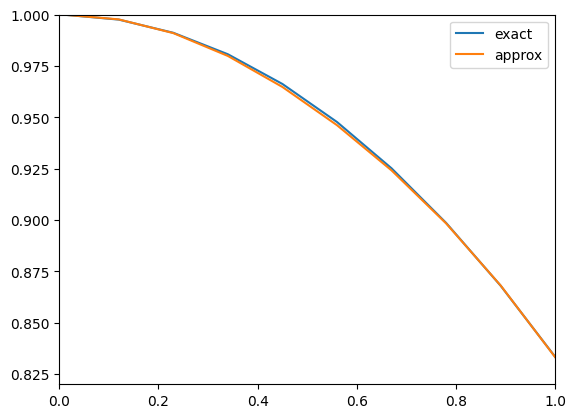

In [ ]:
plt.plot(inputs, 1 - (inputs**2/6), label='exact')
plt.plot(inputs, trial_vect(params, inputs), label='approx')
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0.82, 1])
plt.legend()
plt.show()

In [ ]:
inputs_w0 = jnp.linspace(0.1, 1, num=10)
inputs_w0

Array([0.1       , 0.2       , 0.3       , 0.4       , 0.5       ,
       0.6       , 0.70000005, 0.8       , 0.90000004, 1.        ],      dtype=float32)

In [ ]:
1 - (inputs_w0**2/6)

Array([0.99833333, 0.99333334, 0.985     , 0.97333336, 0.9583333 ,
       0.94      , 0.9183333 , 0.8933333 , 0.865     , 0.8333333 ],      dtype=float32)

In [ ]:
trial_vect(params, inputs_w0)

Array([0.9984347 , 0.9932967 , 0.9844332 , 0.9721212 , 0.9567549 ,
       0.93857914, 0.91752374, 0.89319885, 0.86511207, 0.8331661 ],      dtype=float32)

In [ ]:
jnp.abs((1 - (inputs_w0**2/6)) - trial_vect(params, inputs_w0))

Array([1.0138750e-04, 3.6656857e-05, 5.6684017e-04, 1.2121797e-03,
       1.5783906e-03, 1.4208555e-03, 8.0955029e-04, 1.3446808e-04,
       1.1205673e-04, 1.6719103e-04], dtype=float32)

In [ ]:
print('MAE')
"{:e}".format((1/len(inputs))*jnp.sum(jnp.abs(((1 - (inputs**2/6)) - trial_vect(params, inputs)))).item())

MAE


'5.661011e-04'

In [ ]:
print('MSE')
"{:e}".format((1/len(inputs))*jnp.sum(((1 - (inputs**2/6))-trial_vect(params, inputs))**2))

MSE


'6.391626e-07'

In [ ]:
print('L1 NORM')
"{:e}".format(jnp.linalg.norm((1 - (inputs**2/6))-trial_vect(params, inputs), ord=1))

L1 NORM


'5.661011e-03'

(0.0, 1.0)

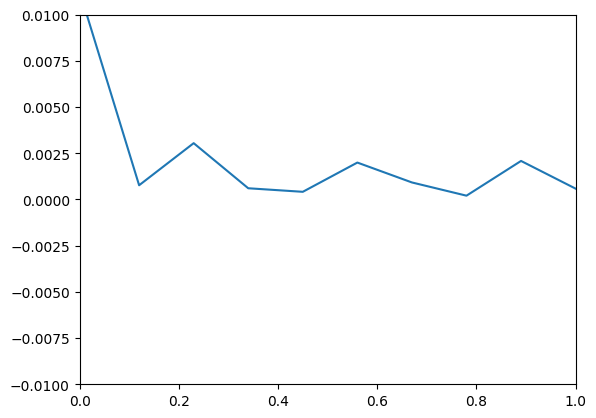

In [ ]:
plt.plot(inputs,
         [jnp.sum(0.5*(grad2_trial(params, num) + (2/num)*grad_trial(params, num) + 1)**2) for num in inputs])
ax = plt.gca()
ax.set_ylim([-0.01, 0.01])
ax.set_xlim([0, 1])